# **MILESTONE 2: ADVANCED TEXT SUMMARIZATION WITH INTERACTIVE UI'S AND VISUALIZATION**
TextMorph: covers advanced text summarization, evaluation with metrics, two interactive UIs in Colab, testing on 10+ sample texts, and visualizing model results with plots.

# **SECTION 1:** Install Libraries
This cell installs all necessary libraries for the application to run.

In [4]:
# -- coding: utf-8 --
# =============================
# INSTALL DEPENDENCIES
# =============================

# Install all required libraries quietly
!pip install ipywidgets transformers torch sentencepiece huggingface_hub pypdf evaluate scikit-learn sentence-transformers matplotlib seaborn pandas nltk textstat rouge_score accelerate --quiet; # accelerate is needed for efficient multi-device model loading
print("✅ All dependencies installed successfully.")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.5/323.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.2/239.2 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 81.8 MB/s eta 0:00:00
✅ All dependencies installed successfully.


# **SECTION 2:** Import Libraries And Authenticate
This cell imports all required Python modules and securely logs into the Hugging Face Hub using your Colab secret.

In [5]:
# -- coding: utf-8 --
# =============================
# SETUP AND AUTHENTICATION
# =============================

# Import Libraries & Authenticate
import os
import ipywidgets as widgets
from IPython.display import display, HTML
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import userdata
from huggingface_hub import login
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import numpy as np
import pypdf
import evaluate
import nltk
import io
import warnings
import time
import textstat
from math import pi

# --- SETUP AND AUTHENTICATION ---
warnings.filterwarnings("ignore")  # Ignore warnings globally

# CORRECTED: Download the 'punkt' resource and the specific 'punkt_tab' to fix the TextRank error
try:
    nltk.download('punkt', quiet=True)
    nltk.download('punkt_tab', quiet=True)  # <-- This line explicitly fixes the error
except Exception as e:
    print(f"Error downloading NLTK data: {e}")

# Securely get the token from Colab secrets and login to Hugging Face Hub
try:
    HF_TOKEN = userdata.get('HF_TOKEN')
    login(token=HF_TOKEN)
    print("✅ Hugging Face Hub login successful.")
except Exception as e:
    print(
        "🛑 Hugging Face Hub login failed. "
        "Please ensure you have set the 'HF_TOKEN' secret correctly.\n"
        f"Error: {e}"
    )

✅ Hugging Face Hub login successful.


# **SECTION 3:** Load AI Models (Pre-computation)
We load models like TinyLlama, Phi-2, BART-large-cnn, Gemma for Abstractive Summarization and TextRank for Extractive Summarization. It loads into the memory before any UI is displayed.

In [6]:
# -- coding: utf-8 --
# =============================
# LOAD MODELS (PRE-COMPUTATION)
# =============================

# Load Models
print("Loading AI models... This may take a few minutes. ⏳")

# Use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Dictionary to hold all loaded models
MODELS = {}

try:
    # --- Abstractive Summarization Models ---

    # Model 1: TinyLlama-1.1B-Chat
    model_id_tiny = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
    MODELS['tinyllama'] = {
        'tokenizer': AutoTokenizer.from_pretrained(model_id_tiny),
        'model': AutoModelForCausalLM.from_pretrained(
            model_id_tiny,
            torch_dtype=torch.bfloat16,
            device_map="auto"
        ),
        'name': "TinyLlama-1.1B-Chat"
    }
    print("✅ Loaded TinyLlama-1.1B-Chat.")

    # Model 2: Phi-2 (microsoft/phi-2)
    model_id_phi = "microsoft/phi-2"
    MODELS['phi'] = {
        'tokenizer': AutoTokenizer.from_pretrained(model_id_phi, trust_remote_code=True),
        'model': AutoModelForCausalLM.from_pretrained(
            model_id_phi,
            torch_dtype=torch.bfloat16,
            device_map="auto",
            trust_remote_code=True
        ),
        'name': "Phi-2"
    }
    print("✅ Loaded Phi-2.")

    # Model 3: BART-Large-CNN
    model_id_bart = "facebook/bart-large-cnn"
    MODELS['bart'] = {
        'summarizer': pipeline(
            "summarization",
            model=model_id_bart,
            device=0 if device=="cuda" else -1
        ),
        'name': "BART-Large-CNN"
    }
    print("✅ Loaded BART-Large-CNN.")

    # Model 4: Gemma-2B-IT
    model_id_gemma = "google/gemma-2b-it"
    MODELS['gemma'] = {
        'tokenizer': AutoTokenizer.from_pretrained(model_id_gemma, trust_remote_code=True),
        'model': AutoModelForCausalLM.from_pretrained(
            model_id_gemma,
            device_map="auto",
            trust_remote_code=True
        ),
        'name': "Gemma-2B-IT"
    }
    print("✅ Loaded Gemma-2B-IT.")

    # --- Extractive Summarization Model (TextRank with embeddings) ---
    MODELS['embedding'] = {
        'model': SentenceTransformer('all-MiniLM-L6-v2', device=device),
        'name': "TextRank (Embeddings)"
    }
    print("✅ Loaded Sentence Transformer for TextRank.")

    print("\n🎉 All models loaded successfully!")

except Exception as e:
    print(f"🛑 Error loading models: {e}. Please check your token and model access permissions.")
    exit()

# --- Load ROUGE metric for evaluation ---
rouge_metric = evaluate.load("rouge")
print("✅ ROUGE metric loaded successfully.")

Loading AI models... This may take a few minutes. ⏳
Using device: cuda


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

✅ Loaded TinyLlama-1.1B-Chat.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

✅ Loaded Phi-2.


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


✅ Loaded BART-Large-CNN.


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

✅ Loaded Gemma-2B-IT.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Loaded Sentence Transformer for TextRank.

🎉 All models loaded successfully!


✅ ROUGE metric loaded successfully.


# **SECTION 4:** Define Shared Backend Logic
This cell defines common functions for text processing, running models, computing metrics, and creating plots used by both UIs.

In [10]:
# -- coding: utf-8 --
# =============================
# SHARED BACKEND LOGIC
# =============================

# --- Model Inference ---

def generate_with_chat_template_model(model_key, prompt, max_new_tokens=250):
    """Handles models like TinyLlama and Gemma that use a chat template."""
    tokenizer = MODELS[model_key]['tokenizer']
    model = MODELS[model_key]['model']
    chat = [{"role": "user", "content": prompt}]
    formatted_prompt = tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer.encode(formatted_prompt, add_special_tokens=False, return_tensors="pt").to(model.device)
    outputs = model.generate(input_ids=inputs, max_new_tokens=max_new_tokens)
    return tokenizer.decode(outputs[0][len(inputs[0]):], skip_special_tokens=True)

def generate_with_instruct_model(model_key, prompt, max_new_tokens=250):
    """Handles models like Phi that use a simple instruction format."""
    tokenizer = MODELS[model_key]['tokenizer']
    model = MODELS[model_key]['model']
    inputs = tokenizer(prompt, return_tensors="pt", return_attention_mask=False).to(model.device)
    outputs = model.generate(**inputs, max_length=len(inputs["input_ids"][0]) + max_new_tokens)
    decoded_output = tokenizer.batch_decode(outputs)[0]
    if "Output:" in decoded_output:
        return decoded_output.split("Output:")[1].strip()
    return decoded_output  # Fallback if format is unexpected

# --- Abstractive Summarization ---
def summarize_abstractive(text, model_key, target_words=150):
    """
    Generates abstractive summary ensuring approx same length across models.
    target_words: approximate number of words desired in summary
    """
    max_tokens = target_words * 2  # rough estimate (model tokens ≈ 2× words)
    truncated_text = text[:2000]  # keep input manageable

    if model_key in ['tinyllama', 'gemma']:
        prompt = f"Provide a concise, abstractive summary of the following text in about {target_words} words:\n\n{truncated_text}"
        summary = generate_with_chat_template_model(model_key, prompt, max_new_tokens=max_tokens)
    elif model_key == 'phi':
        prompt = f"Instruct: Summarize the following text in about {target_words} words.\n{truncated_text}\nOutput:"
        summary = generate_with_instruct_model(model_key, prompt, max_new_tokens=max_tokens)
    elif model_key == 'bart':
        # BART uses max_length in tokens; roughly align with target_words
        summary = MODELS['bart']['summarizer'](
            truncated_text,
            max_length=target_words*2,
            min_length=int(target_words*0.8),
            do_sample=False
        )[0]['summary_text']
    else:
        summary = "Unsupported model."

    # Ensure output length matches target (truncate)
    words = summary.split()
    if len(words) > target_words:
        summary = " ".join(words[:target_words])
    return summary

# --- Extractive Summarization ---
def summarize_extractive(text, model_key, target_words=150):
    """
    Extractive summarization producing approx same length across models.
    target_words: approximate number of words desired in summary
    """
    words_per_sentence = 20  # approximate words per sentence
    num_sentences = max(1, target_words // words_per_sentence)

    if model_key in ['tinyllama', 'gemma']:
        prompt = f"Extract the {num_sentences} most crucial sentences from the following text:\n\n{text[:2000]}"
        summary = generate_with_chat_template_model(model_key, prompt, max_new_tokens=250)
    elif model_key == 'phi':
        prompt = f"Instruct: Extract the {num_sentences} most important sentences from the following text.\n{text[:2000]}\nOutput:"
        summary = generate_with_instruct_model(model_key, prompt, max_new_tokens=250)
    elif model_key == 'embedding':
        try:
            sentences = nltk.sent_tokenize(text)
            if len(sentences) <= num_sentences:
                return " ".join(sentences)
            embeddings = MODELS['embedding']['model'].encode(sentences, convert_to_tensor=True)
            sim_matrix = cosine_similarity(embeddings.cpu().numpy())
            graph = nx.from_numpy_array(sim_matrix)
            scores = nx.pagerank(graph)
            ranked_sentences = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)
            summary = " ".join([s for _, s in ranked_sentences[:num_sentences]])
        except Exception as e:
            summary = f"TextRank failed: {e}"
    else:
        summary = "Unsupported model."

    # Truncate/pad to approx target_words
    words = summary.split()
    if len(words) > target_words:
        summary = " ".join(words[:target_words])
    return summary

# --- Enhanced Metrics and Visualization ---
def calculate_metrics(summary, original_text, processing_time):
    """Calculates evaluation metrics: ROUGE, semantic similarity, readability, length, compression, processing time."""
    embedding_model = MODELS['embedding']['model']
    embeddings = embedding_model.encode([original_text, summary])
    semantic_sim = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]

    rouge_res = rouge_metric.compute(predictions=[summary], references=[original_text])

    return {
        "ROUGE-1": round(rouge_res.get('rouge1', 0.0), 3),
        "ROUGE-2": round(rouge_res.get('rouge2', 0.0), 3),
        "Semantic Similarity": round(semantic_sim, 3),
        "Readability": round(textstat.flesch_reading_ease(summary), 2),
        "Length (words)": len(summary.split()),
        "Time (sec)": round(processing_time, 2),
        "Compression": f"{(1 - (len(summary.split()) / len(original_text.split()))) * 100:.1f}%"
                        if len(original_text.split()) > 0 else "N/A"
    }

def create_bar_charts(metrics_df):
    """Creates bar charts for ROUGE-1, Semantic Similarity, and Processing Time."""
    if metrics_df.empty:
        return None

    df_sorted = metrics_df.sort_values(by=['Model']).reset_index(drop=True)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Model Performance Comparison', fontsize=16)

    sns.barplot(data=df_sorted, x='Model', y='ROUGE-1', ax=axes[0], palette='viridis').tick_params(axis='x', rotation=45)
    axes[0].set_title('ROUGE-1 Score')

    sns.barplot(data=df_sorted, x='Model', y='Semantic Similarity', ax=axes[1], palette='viridis').tick_params(axis='x', rotation=45)
    axes[1].set_title('Semantic Similarity')

    sns.barplot(data=df_sorted, x='Model', y='Time (sec)', ax=axes[2], palette='viridis').tick_params(axis='x', rotation=45)
    axes[2].set_title('Processing Time (seconds)')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig

def create_radar_chart(metrics_df):
    """Creates a radar chart for multi-metric comparison: ROUGE-1, Semantic Similarity, Readability."""
    if metrics_df.empty:
        return None

    metrics_to_plot = ['ROUGE-1', 'Semantic Similarity', 'Readability']
    df_radar = metrics_df.copy()
    df_radar['Readability'] = np.clip(df_radar['Readability'] / 100.0, 0, 1)

    df_avg = df_radar.groupby('Model')[metrics_to_plot].mean().reset_index()
    labels, num_vars = df_avg.columns[1:], len(df_avg.columns[1:])
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist() + [0]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    for i, row in df_avg.iterrows():
        values = row.drop('Model').tolist() + [row.drop('Model').tolist()[0]]
        ax.plot(angles, values, label=row['Model'], linewidth=2)
        ax.fill(angles, values, alpha=0.25)

    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    ax.set_title("Multi-Metric Model Comparison", size=15, y=1.1)
    return fig

print("✅ Shared backend functions are defined")

✅ Shared backend functions are defined


# **SECTION 5:** Input Sample Texts
This cell has 10 sample texts from different domains

In [11]:
# --- Sample Inputs ---
sample_texts = [
    """Sample text 1: Nature is the living, breathing tapestry of our planet, encompassing everything from towering mountains to tiny insects, vast oceans to silent forests. It operates through a complex system of interdependent relationships, where every plant, animal, and microbe plays a role in maintaining balance. This intricate web of life not only sustains ecosystems but also provides essential resources like clean air, fresh water, and fertile soil that humans rely on for survival.Spending time in nature has been proven to have significant mental and physical health benefits. The sounds of rustling leaves, the sight of open landscapes, and the scent of fresh earth can reduce stress, improve mood, and enhance concentration. Whether it’s a hike through a forest trail, a swim in the ocean, or simply sitting under a tree, nature has a calming effect that reconnects people to a sense of peace and wonder often lost in modern, urban life.However, the natural world is increasingly under threat from human activities such as deforestation, pollution, and climate change. These actions disrupt delicate ecosystems and endanger countless species, including our own. Protecting and preserving nature is not just an environmental issue but a necessity for future generations. By embracing sustainable practices and fostering respect for the environment, humanity can help restore the balance and ensure that the beauty and benefits of nature endure.""",
    """Sample text 2: Climate change refers to long-term shifts in temperatures and weather patterns, primarily driven by human activities such as burning fossil fuels, deforestation, and industrial processes. These actions release greenhouse gases like carbon dioxide and methane into the atmosphere, trapping heat and disrupting Earth's natural climate systems. As a result, global temperatures have been rising at an unprecedented rate, leading to more extreme and unpredictable weather conditions.The impacts of climate change are already being felt across the globe. Rising sea levels threaten coastal communities, while severe droughts and floods affect food and water supplies. Heatwaves, wildfires, and stronger hurricanes are becoming more frequent and intense. These changes not only harm the environment but also pose serious risks to human health, livelihoods, and infrastructure, particularly in vulnerable regions with fewer resources to adapt.Addressing climate change requires urgent global cooperation and action. This includes reducing greenhouse gas emissions, transitioning to renewable energy sources, protecting forests, and investing in sustainable technologies. On an individual level, people can contribute by conserving energy, reducing waste, and supporting climate-conscious policies. The window for meaningful action is narrowing, but with commitment and innovation, it is still possible to limit the worst effects of climate change and protect the planet for future generations.""",
    """Sample text 3: Artificial Intelligence (AI) is the field of computer science focused on creating systems that can perform tasks typically requiring human intelligence. These tasks include understanding natural language, recognizing images, making decisions, and learning from data. AI systems use algorithms and large datasets to identify patterns, solve problems, and improve their performance over time—often with minimal human intervention.AI is already transforming many industries. In healthcare, it helps diagnose diseases and recommend treatments; in finance, it detects fraud and manages investments; in transportation, it's powering self-driving vehicles. Everyday applications like voice assistants, recommendation engines (like those on YouTube or Netflix), and language translation tools are also built on AI technologies. Its ability to analyze massive amounts of data quickly makes it a valuable tool across countless fields.However, AI also raises important ethical and social questions. Concerns include job displacement due to automation, biases in decision-making systems, privacy risks, and the need for transparency in how AI models work. Ensuring that AI is developed and used responsibly is crucial. This involves setting clear regulations, promoting fairness and accountability, and designing systems that align with human values and societal needs.""",
    """Sample text 4: The stock market is a platform where investors buy and sell shares of publicly traded companies. It serves as a key part of the global financial system, allowing businesses to raise capital by offering ownership stakes (stocks) to the public. Investors, in turn, hope to earn profits through stock price increases or dividends. Major stock markets include the New York Stock Exchange (NYSE), Nasdaq, and other global exchanges like the London Stock Exchange or Bombay Stock Exchange.Stock prices are influenced by many factors, including company performance, industry trends, economic indicators, and investor sentiment. For example, if a company reports strong earnings, its stock price may rise as investors gain confidence. Conversely, news of a weak economy or political instability can cause market volatility. Because of these dynamics, investing in stocks carries both opportunities and risks, and it often requires research, strategy, and a long-term mindset.Beyond individual investing, the stock market also reflects the overall health of an economy. When markets are performing well, it can indicate economic growth and business confidence. However, sharp declines or crashes—like those during financial crises—can lead to fear, job losses, and reduced consumer spending. As a result, governments and central banks closely monitor and sometimes intervene in markets to maintain stability and encourage economic resilience.""",
    """Sample text 5: Pollution is the introduction of harmful substances or energy into the environment, causing negative effects on nature and human health. It can come from various sources such as factories, vehicles, agriculture, and waste disposal. The main types of pollution include air pollution, water pollution, soil pollution, and noise pollution. Each of these affects ecosystems differently and often leads to long-term damage if not controlled.Air pollution is one of the most widespread and dangerous forms, caused mainly by emissions from vehicles, industries, and burning fossil fuels. It leads to serious health problems like asthma, lung diseases, and heart conditions. Water pollution, caused by industrial waste, plastic, sewage, and chemicals, harms marine life and contaminates drinking water sources. Soil pollution from pesticides and waste affects food safety and reduces soil fertility, while noise pollution from traffic, construction, and loudspeakers affects mental well-being.Tackling pollution requires collective efforts from individuals, industries, and governments. Solutions include using cleaner energy sources, reducing plastic use, proper waste management, and stricter environmental regulations. Public awareness and education also play a key role in changing habits and promoting sustainable living. By reducing pollution, we not only protect the environment but also ensure a healthier, safer world for current and future generations.""",
    """Sample text 6: Life in Japan is a blend of tradition and modernity, where ancient customs coexist with cutting-edge technology. Cities like Tokyo and Osaka are known for their fast-paced lifestyles, efficient public transportation, and advanced infrastructure. Meanwhile, rural areas offer a quieter, more traditional way of life with scenic landscapes, rice fields, and a strong sense of community. Japanese culture places a high value on respect, politeness, and cleanliness, which is reflected in daily interactions and public behavior.Work and education are central parts of life in Japan. The work culture is known for being demanding, with long hours and a strong sense of dedication to the company. However, there has been growing awareness of the need for better work-life balance. Education is rigorous and competitive, with students often attending extra classes or “juku” (cram schools) to prepare for exams. Despite the pressure, there is also a strong sense of discipline, responsibility, and group harmony that shapes both school and work environments.Outside of work and school, Japan offers a rich cultural and social life. From cherry blossom festivals and traditional tea ceremonies to anime, video games, and high-tech entertainment, there's something for everyone. The food culture is also diverse and widely appreciated, with dishes like sushi, ramen, and tempura enjoyed both locally and internationally. Whether living in a busy city or a peaceful countryside town, life in Japan is marked by a deep respect for nature, community, and continuous improvement.""",
    """Sample text 7: The afterlife refers to the concept of existence beyond physical death—a belief found in many religions, spiritual traditions, and philosophies. What happens after we die has been one of humanity's most profound and enduring questions. Some belief systems describe a continuation of the soul in another realm, while others suggest reincarnation or a return to the universe in some spiritual form. Though ideas vary widely, most share the idea that death is not the end, but a transition.In religious contexts, the afterlife is often tied to moral behavior in life. For example, in Christianity, it’s believed that souls go to heaven or hell based on their actions and faith. In Hinduism and Buddhism, the soul is reborn in a cycle of reincarnation, influenced by karma—the consequences of one’s actions. Meanwhile, some belief systems like certain branches of atheism or secular humanism see death as the end of consciousness, where no afterlife exists, only the legacy we leave behind.While there's no scientific proof of an afterlife, the belief in it can provide comfort, hope, and guidance. It helps people cope with grief, find meaning in suffering, and live with a sense of purpose. Whether viewed as a literal destination, a spiritual journey, or a symbolic idea, the afterlife continues to influence how cultures approach life, death, and what it means to be human.""",
    """Sample text 8: Pollution in India is a serious and growing concern that affects the health of millions and the sustainability of its environment. The most prominent types of pollution in the country are air pollution, water pollution, and land pollution. Rapid urbanization, industrialization, and population growth have put immense pressure on natural resources and led to widespread environmental degradation. Major cities like Delhi, Mumbai, and Kolkata often struggle with high levels of pollution due to vehicle emissions, construction dust, and industrial waste.Air pollution is especially severe in northern India, where smog and particulate matter levels often exceed safe limits. Delhi, in particular, frequently ranks among the most polluted cities in the world, especially during the winter months due to crop stubble burning, firecrackers, and weather conditions that trap pollutants close to the ground. Water pollution is also a critical issue, with rivers like the Ganges and Yamuna being heavily contaminated by sewage, industrial discharge, and religious offerings. This affects not only aquatic life but also the health of communities that rely on these water sources for drinking and daily use.To combat pollution, the Indian government has taken various steps, including launching programs like the National Clean Air Programme (NCAP) and Swachh Bharat Abhiyan (Clean India Mission). There is also growing public awareness and activism pushing for stricter enforcement of environmental laws and sustainable practices. However, more effective implementation, better waste management systems, and a shift toward green technologies are needed to achieve lasting results. Controlling pollution is essential not only for protecting the environment but also for improving the quality of life and health for people across the country.""",
    """Sample text 9: Cybersecurity is the practice of protecting computers, networks, data, and digital systems from unauthorized access, attacks, or damage. As technology becomes more deeply integrated into daily life—through online banking, social media, e-commerce, and cloud storage—securing digital information has become critically important. Cyber threats can come in many forms, such as viruses, malware, ransomware, phishing attacks, and data breaches, often targeting both individuals and organizations.For businesses and governments, cybersecurity is essential to prevent financial losses, protect sensitive data, and maintain trust. A single cyberattack can lead to the loss of millions of dollars, leak confidential information, or even disrupt national infrastructure. As a result, many organizations invest in firewalls, encryption, intrusion detection systems, and regular security audits. Cybersecurity professionals play a key role in monitoring threats, responding to incidents, and building systems that are resistant to attacks.On a personal level, cybersecurity involves practicing safe habits like using strong passwords, enabling two-factor authentication, keeping software updated, and being cautious about suspicious emails or links. With the rise of remote work and increased internet usage, cyber hygiene is more important than ever. As threats continue to evolve, so must our defenses—making cybersecurity a constantly changing field that requires awareness, education, and ongoing innovation.""",
    """Sample text 10: Anime is a style of animated entertainment that originated in Japan and has grown into a global phenomenon. Unlike typical cartoons, anime covers a wide range of genres and themes, from action and adventure to romance, fantasy, horror, and science fiction. It often features distinctive art styles, vibrant characters, and complex storytelling that appeals to both children and adults. Popular series like Naruto, Dragon Ball, One Piece, and Attack on Titan have gained massive international fan bases.One unique aspect of anime is its deep connection to Japanese culture and traditions, which are frequently woven into storylines, character designs, and settings. Anime can explore philosophical questions, social issues, and emotional experiences, making it much more than simple entertainment. Additionally, anime is not limited to TV shows; it includes movies, web series, manga (comic books), and video games, creating a rich and immersive cultural ecosystem.The global popularity of anime has led to a vibrant community of fans who create fan art, cosplay, and conventions celebrating the medium. Streaming platforms and online communities have made anime more accessible worldwide, fueling interest across all ages and backgrounds. With its creativity, emotional depth, and cultural richness, anime continues to inspire and connect people everywhere."""
]

# **SECTION A:** Summarize with All Models (Prompt UI)
This UI is simplified for quick comparisons. Just paste your text or choose from the sample texts, choose the summary type, and it will automatically run all compatible

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


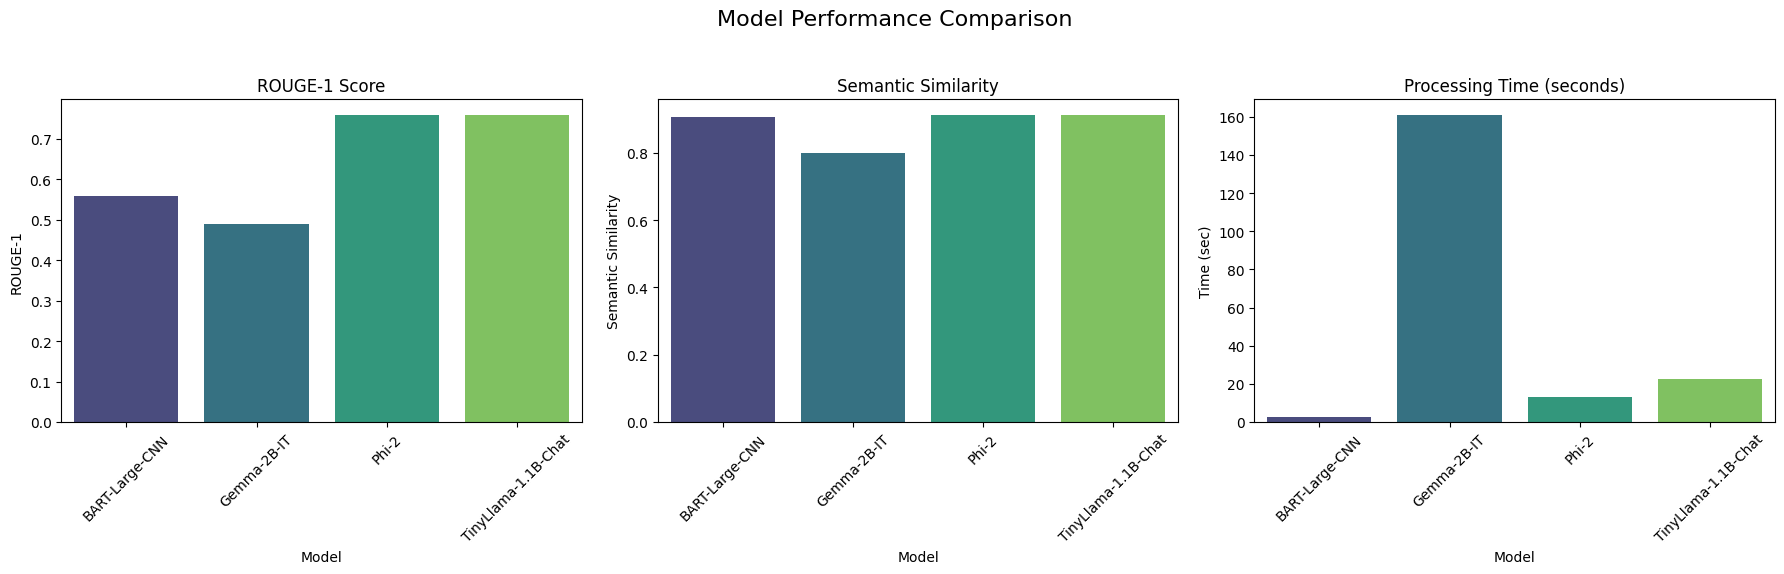

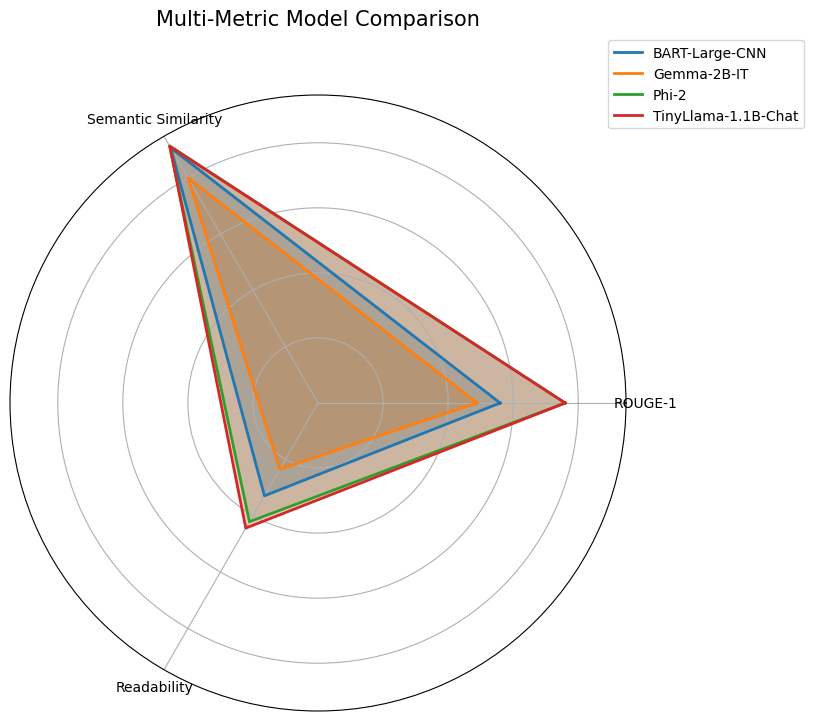

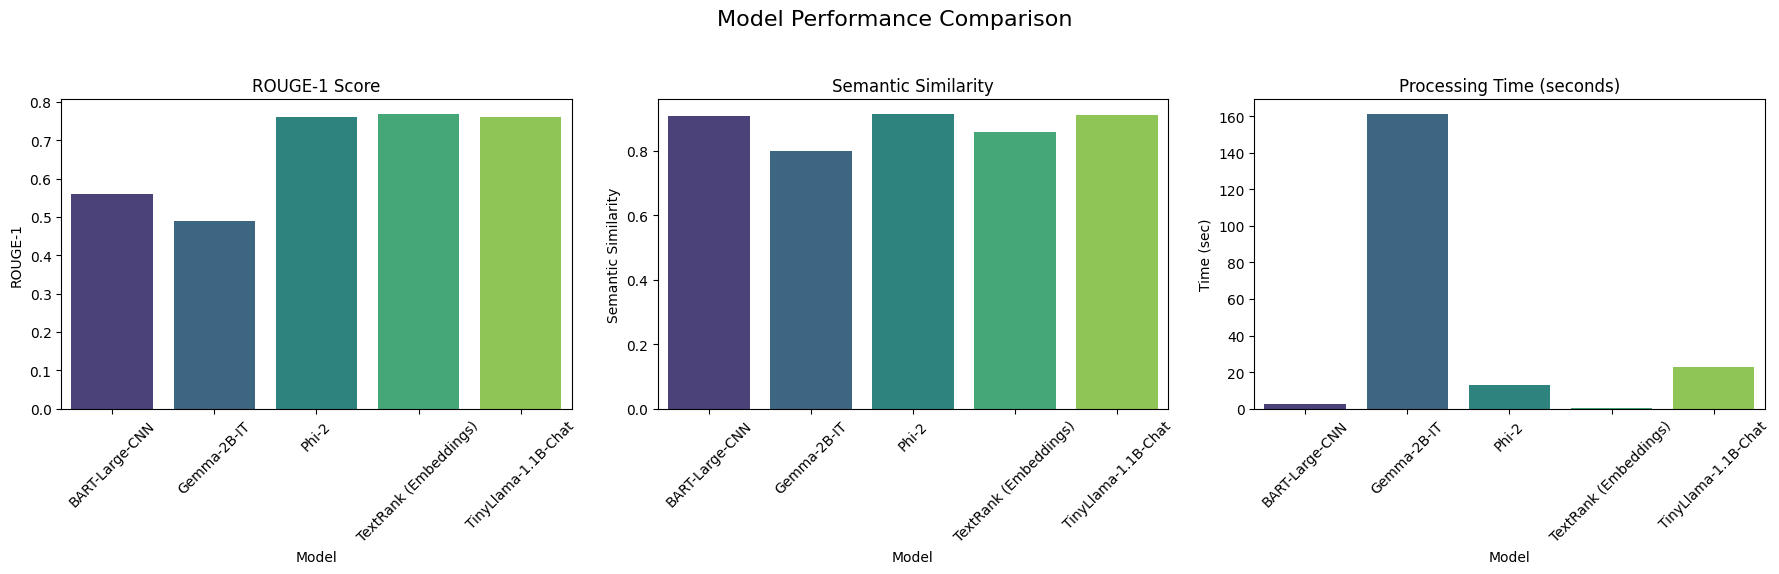

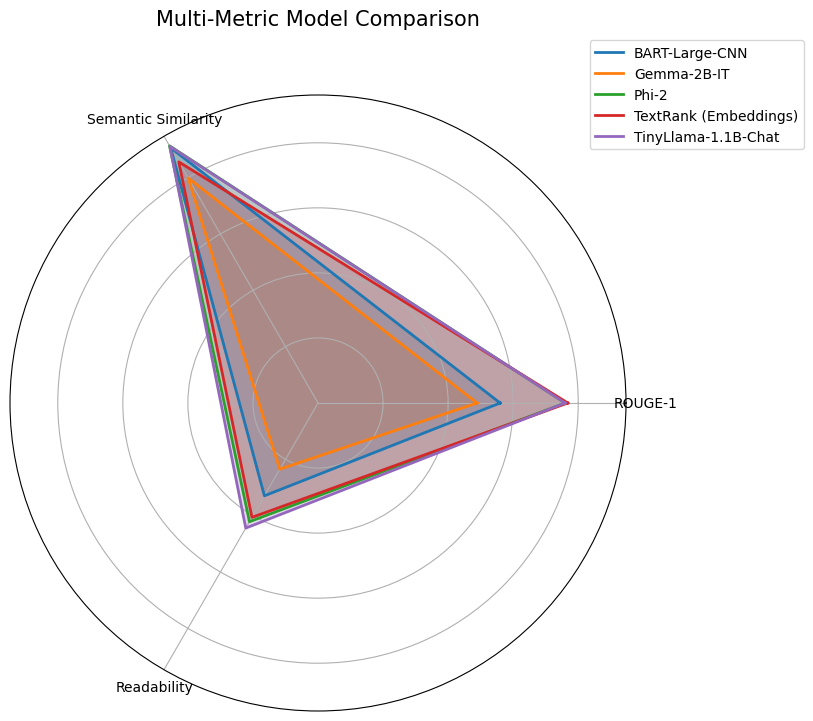

In [12]:
# --- SECTION A: RUN ALL MODELS UI ---

# --- State and Choices ---
metrics_history_all = []

#  Abstractive summarization models now include TinyLlama, Phi, BART, and Gemma
abstractive_model_choices = {
    MODELS['tinyllama']['name']: 'tinyllama',
    MODELS['phi']['name']: 'phi',
    MODELS['bart']['name']: 'bart',
    MODELS['gemma']['name']: 'gemma'
}

#  Extractive summarization models: TinyLlama, Phi, and TextRank (embedding)
extractive_model_choices = {
    MODELS['embedding']['name']: 'embedding'
}

# --- Sample Inputs Radio Buttons ---
sample_inputs_radio = widgets.RadioButtons(
    options=["None"] + [f"Sample {i+1}" for i in range(len(sample_texts))],
    description='Sample Inputs:',
    layout={'width': '95%'},
    style={'description_width': 'initial'}
)

def on_sample_selected(change):
    if change['new'] is not None:
        if change['new'] == "None":
            # User will manually input text; do not change textarea
            return
        else:
            idx = int(change['new'].split()[1]) - 1
            prompt_input_all.value = sample_texts[idx]

sample_inputs_radio.observe(on_sample_selected, names='value')

# --- UI Widget Definitions ---
header_all = widgets.HTML("<h2>Section A: Summarize with All Models</h2><p>Paste text and choose a summary type. The system will automatically run all compatible models for a full comparison.</p>")
prompt_input_all = widgets.Textarea(placeholder='Paste your text here to summarize...', layout={'height': '200px', 'width': '99%'})
summary_type_all = widgets.RadioButtons(options=['Abstractive', 'Extractive'], value='Abstractive', description='Summ. Type:')
generate_button_all = widgets.Button(description='🚀 Generate All Summaries', button_style='primary', icon='cogs')
clear_button_all = widgets.Button(description='🧹 Clear Outputs', button_style='warning', icon='trash')

# --- Output Widget Definitions ---
summary_output_all = widgets.Output(layout={'height': '400px', 'border': '1px solid #ccc', 'padding': '10px', 'overflow': 'scroll'})
metrics_table_output_all = widgets.Output()
bar_plot_output_all = widgets.Output()
radar_plot_output_all = widgets.Output()
output_accordion_all = widgets.Accordion(children=[metrics_table_output_all, bar_plot_output_all, radar_plot_output_all])
output_accordion_all.set_title(0, '📊 Metrics Table')
output_accordion_all.set_title(1, '📈 Bar Charts')
output_accordion_all.set_title(2, '✨ Radar Plot')

# --- Event Handlers ---
def on_generate_button_clicked_all(b):
    generate_button_all.disabled = True
    generate_button_all.description = "Processing..."
    original_text, s_type = prompt_input_all.value, summary_type_all.value
    if not original_text.strip():
        with summary_output_all: print("⚠ Please paste text to summarize.")
        generate_button_all.disabled = False
        generate_button_all.description = "🚀 Generate All Summaries"
        return

    s_keys = list(abstractive_model_choices.values()) if s_type == 'Abstractive' else list(extractive_model_choices.values())

    with summary_output_all: display(HTML(f"<hr><h2>Processing Pasted Text ({s_type})</h2>"))
    for model_key in s_keys:
        model_name = MODELS[model_key]['name']
        with summary_output_all: print(f"⏳ Summarizing with {model_name}...")
        start_time = time.time()
        summary = summarize_abstractive(original_text, model_key) if s_type == "Abstractive" else summarize_extractive(original_text, model_key)
        proc_time = time.time() - start_time
        with summary_output_all: display(HTML(f"<h3>Summary from {model_name}</h3><p>{summary}</p>"))
        metrics = calculate_metrics(summary, original_text, proc_time)
        metrics.update({'Model': model_name, 'File': 'Pasted Text', 'Type': s_type})
        metrics_history_all.append(metrics)

    df = pd.DataFrame(metrics_history_all)
    with metrics_table_output_all: metrics_table_output_all.clear_output(wait=True); display(df)
    with bar_plot_output_all: bar_plot_output_all.clear_output(wait=True); display(create_bar_charts(df))
    with radar_plot_output_all: radar_plot_output_all.clear_output(wait=True); display(create_radar_chart(df))
    generate_button_all.disabled = False
    generate_button_all.description = "🚀 Generate All Summaries"

def on_clear_button_clicked_all(b):
    global metrics_history_all
    metrics_history_all = []
    summary_output_all.clear_output()
    metrics_table_output_all.clear_output()
    bar_plot_output_all.clear_output()
    radar_plot_output_all.clear_output()
    prompt_input_all.value = ""
    sample_inputs_radio.value = "None"
    with summary_output_all: print("Outputs cleared.")

generate_button_all.on_click(on_generate_button_clicked_all)
clear_button_all.on_click(on_clear_button_clicked_all)

# --- Assemble and Display UI with Sample Inputs ---
input_controls_all = widgets.VBox(
    [prompt_input_all, summary_type_all, sample_inputs_radio, widgets.HBox([generate_button_all, clear_button_all])],
    layout=widgets.Layout(width='35%', padding='10px', border='1px solid lightgrey', border_radius='5px')
)
output_area_all = widgets.VBox(
    [summary_output_all, output_accordion_all],
    layout=widgets.Layout(width='65%', padding='10px')
)
app_all = widgets.VBox([header_all, widgets.HBox([input_controls_all, output_area_all])])

display(app_all)

# **SECTION B:** Summarize with Specific Models (CheckBox UI)
This UI gives you fine-grained control, allowing you to select exaclty which models you want to run using checkboxes.

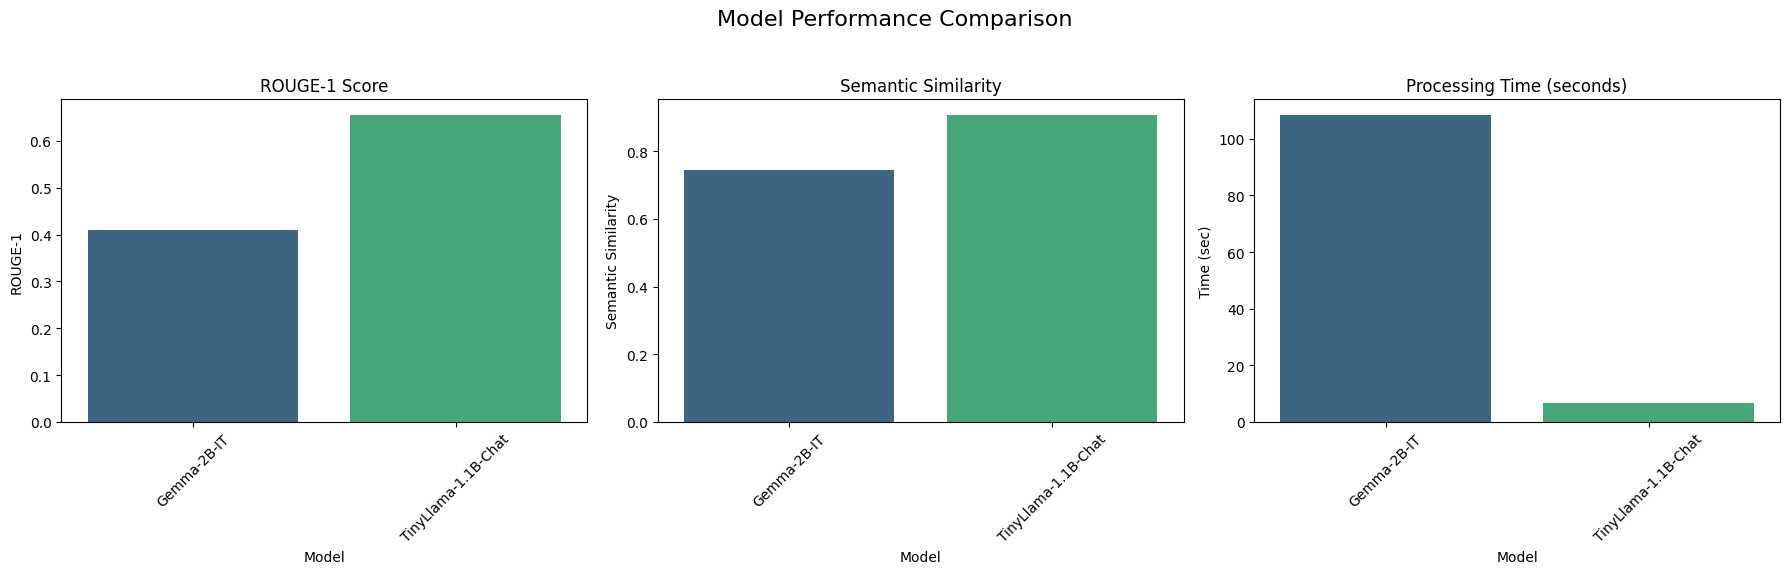

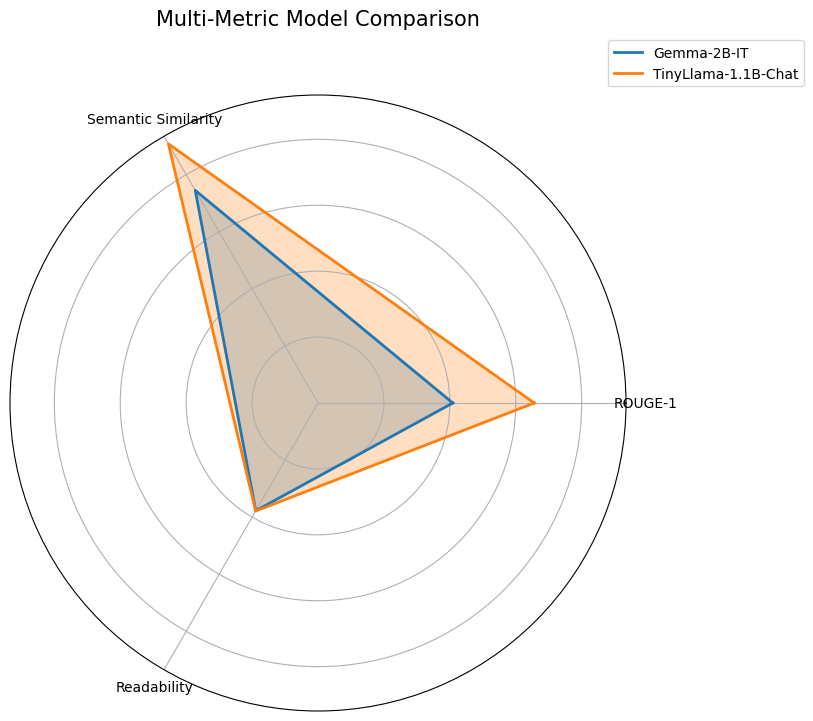

In [13]:
# --- SECTION B: SELECT SPECIFIC MODELS UI ---

# --- State and Choices ---
metrics_history_specific = []

# Reuse choices with Gemma and TextRank
abstractive_model_choices = {
    MODELS['tinyllama']['name']: 'tinyllama',
    MODELS['phi']['name']: 'phi',
    MODELS['bart']['name']: 'bart',
    MODELS['gemma']['name']: 'gemma'
}
extractive_model_choices = {
    MODELS['embedding']['name']: 'embedding'
}

# --- Sample Inputs Radio Buttons ---
sample_inputs_radio = widgets.RadioButtons(
    options=["None"] + [f"Sample {i+1}" for i in range(len(sample_texts))],
    description='Sample Inputs:',
    layout={'width': '95%'},
    style={'description_width': 'initial'}
)

def on_sample_selected_specific(change):
    if change['new'] is not None:
        if change['new'] == "None":
            return  # User will manually input text
        else:
            idx = int(change['new'].split()[1]) - 1
            prompt_input_specific.value = sample_texts[idx]

sample_inputs_radio.observe(on_sample_selected_specific, names='value')

# --- UI Widget Definitions ---
header_specific = widgets.HTML("<h2>Section B: Summarize with Specific Models</h2><p>Paste text, choose a summary type, and check the specific models you want to run.</p>")
prompt_input_specific = widgets.Textarea(placeholder='Paste your text here to summarize...', layout={'height': '200px', 'width': '99%'})
summary_type_specific = widgets.RadioButtons(options=['Abstractive', 'Extractive'], value='Abstractive', description='Summ. Type:')
model_checkboxes_out = widgets.Output()
checkboxes = {}
generate_button_specific = widgets.Button(description='🚀 Generate Summaries', button_style='primary', icon='cogs')
clear_button_specific = widgets.Button(description='🧹 Clear Outputs', button_style='warning', icon='trash')

# --- Output Widget Definitions ---
summary_output_specific = widgets.Output(layout={'height': '400px', 'border': '1px solid #ccc', 'padding': '10px', 'overflow': 'scroll'})
metrics_table_output_specific = widgets.Output()
bar_plot_output_specific = widgets.Output()
radar_plot_output_specific = widgets.Output()
output_accordion_specific = widgets.Accordion(children=[metrics_table_output_specific, bar_plot_output_specific, radar_plot_output_specific])
output_accordion_specific.set_title(0, '📊 Metrics Table')
output_accordion_specific.set_title(1, '📈 Bar Charts')
output_accordion_specific.set_title(2, '✨ Radar Plot')

# --- Event Handlers ---
def update_checkboxes(s_type):
    """Populate checkboxes based on summary type."""
    global checkboxes
    checkboxes = {}
    choices = abstractive_model_choices if s_type == 'Abstractive' else extractive_model_choices
    with model_checkboxes_out:
        model_checkboxes_out.clear_output(wait=True)
        for name, key in choices.items():
            checkboxes[key] = widgets.Checkbox(value=True, description=name)
        display(widgets.VBox(list(checkboxes.values())))

def on_generate_button_clicked_specific(b):
    generate_button_specific.disabled = True
    generate_button_specific.description = "Processing..."
    original_text, s_type = prompt_input_specific.value, summary_type_specific.value
    s_keys = [key for key, cb in checkboxes.items() if cb.value]

    if not original_text.strip() or not s_keys:
        with summary_output_specific: print("⚠ Please paste text and check at least one model.")
        generate_button_specific.disabled = False
        generate_button_specific.description = "🚀 Generate Summaries"
        return

    with summary_output_specific: display(HTML(f"<hr><h2>Processing Pasted Text ({s_type})</h2>"))
    for model_key in s_keys:
        model_name = MODELS[model_key]['name']
        with summary_output_specific: print(f"⏳ Summarizing with {model_name}...")
        start_time = time.time()
        summary = summarize_abstractive(original_text, model_key) if s_type == "Abstractive" else summarize_extractive(original_text, model_key)
        proc_time = time.time() - start_time
        with summary_output_specific: display(HTML(f"<h3>Summary from {model_name}</h3><p>{summary}</p>"))
        metrics = calculate_metrics(summary, original_text, proc_time)
        metrics.update({'Model': model_name, 'File': 'Pasted Text', 'Type': s_type})
        metrics_history_specific.append(metrics)

    df = pd.DataFrame(metrics_history_specific)
    with metrics_table_output_specific: metrics_table_output_specific.clear_output(wait=True); display(df)
    with bar_plot_output_specific: bar_plot_output_specific.clear_output(wait=True); display(create_bar_charts(df))
    with radar_plot_output_specific: radar_plot_output_specific.clear_output(wait=True); display(create_radar_chart(df))
    generate_button_specific.disabled = False
    generate_button_specific.description = "🚀 Generate Summaries"

def on_clear_button_clicked_specific(b):
    global metrics_history_specific
    metrics_history_specific = []
    summary_output_specific.clear_output()
    metrics_table_output_specific.clear_output()
    bar_plot_output_specific.clear_output()
    radar_plot_output_specific.clear_output()
    prompt_input_specific.value = ""
    sample_inputs_radio.value = "None"
    with summary_output_specific: print("Outputs cleared.")

def on_summary_type_change_specific(change):
    update_checkboxes(change.new)

# --- Bind events ---
generate_button_specific.on_click(on_generate_button_clicked_specific)
clear_button_specific.on_click(on_clear_button_clicked_specific)
summary_type_specific.observe(on_summary_type_change_specific, names='value')

# --- Assemble and Display UI with Sample Inputs ---
input_controls_specific = widgets.VBox(
    [prompt_input_specific, summary_type_specific, sample_inputs_radio, widgets.Label("Select Models:"), model_checkboxes_out, widgets.HBox([generate_button_specific, clear_button_specific])],
    layout=widgets.Layout(width='35%', padding='10px', border='1px solid lightgrey', border_radius='5px')
)
output_area_specific = widgets.VBox(
    [summary_output_specific, output_accordion_specific],
    layout=widgets.Layout(width='65%', padding='10px')
)
app_specific = widgets.VBox([header_specific, widgets.HBox([input_controls_specific, output_area_specific])])

# Initial population of checkboxes
update_checkboxes('Abstractive')

display(app_specific)